In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

class MRNADataset(Dataset):
    def __init__(self, data_path, labels_path):
        # Load mRNA data and exclude the first column (patient IDs)
        self.mrna_data = torch.tensor(pd.read_csv(data_path, header=0).iloc[:, 1:].values, dtype=torch.float32)

        # remove nan columns
        self.mrna_data = self.mrna_data[:, ~torch.isnan(self.mrna_data).any(0)]

        self.mrna_data = torch.tensor(
            StandardScaler().fit_transform(self.mrna_data.numpy()),
            dtype=torch.float32
        )

        # Reduce to 500 components
        # pca = PCA(n_components=1000)
        # self.mrna_data = torch.tensor(
        #     pca.fit_transform(self.mrna_data.numpy()),
        #     dtype=torch.float32
        # )
             
        # Load survival binary labels
        self.labels = torch.tensor(pd.read_csv(labels_path)["SURVIVAL_BINARY"].values, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.mrna_data[idx], self.labels[idx]

# Example paths
data_path = "brca_metabric/dataset/mrna_zscores.csv"
labels_path = "brca_metabric/dataset/labels.csv"

# Create DataLoader
dataset = MRNADataset(data_path, labels_path)


# split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Test DataLoader
for data, labels in dataloader:
    print(data.shape)  # Should match [batch_size, num_genes]
    print(labels.shape)  # Should match [batch_size]
    break


torch.Size([32, 20592])
torch.Size([32])


In [22]:
class DeepGeneTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, n_heads=8, n_layers=2, dropout_rate=0.3):
        super(DeepGeneTransformer, self).__init__()

        # 1D CNN for feature reduction
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=2)  # input_dim -> 16 channels
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=2)  # 16 channels -> 32 channels
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduce length by half
        self.relu = nn.ReLU()

        # Compute the output size of the CNN dynamically
        dummy_input = torch.zeros(1, 1, input_dim)  # Batch size=1, channels=1, sequence length=input_dim
        cnn_out = self._compute_cnn_output_size(dummy_input)
        self.cnn_output_dim = cnn_out[1] * cnn_out[2]  # Channels x reduced sequence length

        # Transformer encoder block
        self.embedding = nn.Linear(self.cnn_output_dim, hidden_dim)  # Flatten CNN output for embedding
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=n_layers)

        # Fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )

    def _compute_cnn_output_size(self, x):
        """Helper function to compute output size after CNN layers."""
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        return x.shape  # Return the shape of the tensor after CNN

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add channel dimension for 1D CNN

        # Apply first CNN layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Apply second CNN layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten for the Transformer
        x = x.view(x.size(0), -1)  # Flatten into [batch_size, cnn_output_dim]
        x = self.embedding(x)
        x = x.unsqueeze(0)  # Add sequence dimension for Transformer

        # Transformer Encoder
        x = self.transformer_encoder(x)
        x = x.squeeze(0)  # Remove sequence dimension

        # Pool and classify
        x = self.fc(x)
        return x


In [25]:
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import numpy as np

# Parameters
input_dim = 20592  # Example gene count
num_classes = 2    # Binary classification
batch_size = 32
hidden_dim = 128   # Transformer hidden dimension
epochs = 5

# Initialize Model
model = DeepGeneTransformer(
    input_dim=input_dim,
    num_classes=num_classes,
    hidden_dim=hidden_dim
)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()


# Training Function with Validation
def train_with_validation(
    model, train_dataloader, val_dataloader, optimizer, criterion, epochs=10
):
    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        correct_train_preds = 0
        total_train_samples = 0

        for batch in train_dataloader:
            data, labels = batch

            optimizer.zero_grad()

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)
            total_train_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predictions = torch.max(outputs, dim=1)
            correct_train_preds += (predictions == labels).sum().item()
            total_train_samples += labels.size(0)

        train_accuracy = correct_train_preds / total_train_samples
        avg_train_loss = total_train_loss / len(train_dataloader)

        # Validation Phase
        model.eval()
        total_val_loss = 0
        correct_val_preds = 0
        total_val_samples = 0

        with torch.no_grad():
            for batch in val_dataloader:
                data, labels = batch

                # Forward pass
                outputs = model(data)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                # Calculate validation accuracy
                _, predictions = torch.max(outputs, dim=1)
                correct_val_preds += (predictions == labels).sum().item()
                total_val_samples += labels.size(0)

        val_accuracy = correct_val_preds / total_val_samples
        avg_val_loss = total_val_loss / len(val_dataloader)

        print(
            f"Epoch {epoch + 1}/{epochs} | "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
        )


train_with_validation(
    model,
    train_dataloader=dataloader,
    val_dataloader=test_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs
)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/5 | Train Loss: 0.5881, Train Accuracy: 0.7361 | Val Loss: 0.5178, Val Accuracy: 0.7879
Epoch 2/5 | Train Loss: 0.5791, Train Accuracy: 0.7431 | Val Loss: 0.5126, Val Accuracy: 0.7879
Epoch 3/5 | Train Loss: 0.5804, Train Accuracy: 0.7431 | Val Loss: 0.5097, Val Accuracy: 0.7879
Epoch 4/5 | Train Loss: 0.5774, Train Accuracy: 0.7431 | Val Loss: 0.5145, Val Accuracy: 0.7879
Epoch 5/5 | Train Loss: 0.5742, Train Accuracy: 0.7431 | Val Loss: 0.5185, Val Accuracy: 0.7879


Test Loss: 1.1931
Pos to Neg ratio in test set: 3.7143
Predicted Pos to Neg ratio in test set: 2.6330
Accuracy: 0.6742
F1 Score: 0.7846
AUC: 0.6005
AUPRC: 0.8425
Precision: 0.8188
Recall: 0.7532
Specificity: 0.3810
MCC: 0.1228
Confusion Matrix: 
[[ 32  52]
 [ 77 235]]


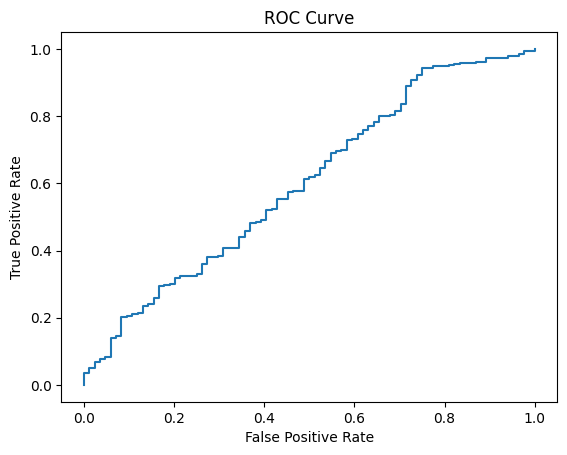

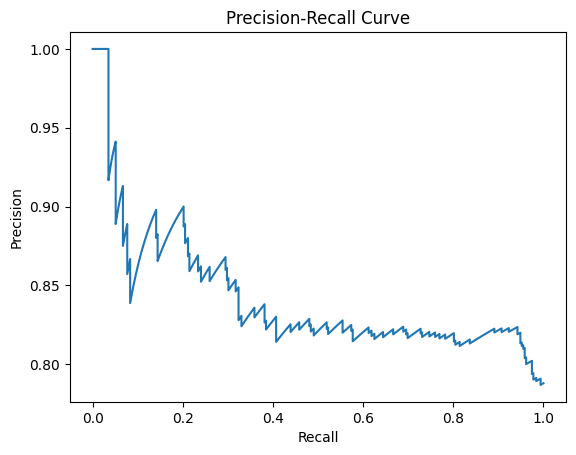

In [24]:
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_score, recall_score,
    confusion_matrix, matthews_corrcoef, average_precision_score, roc_curve, precision_recall_curve
)

import matplotlib.pyplot as plt

def calculate_metrics(all_labels, all_predictions, all_probs=None):
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    prec = precision_score(all_labels, all_predictions)
    rec = recall_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)
    mcc = matthews_corrcoef(all_labels, all_predictions)
    
    # For AUC and AUPRC, use probabilities if provided
    auc = roc_auc_score(all_labels, all_probs) if all_probs is not None else None
    auprc = average_precision_score(all_labels, all_probs) if all_probs is not None else None

    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # Specificity (negative class)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}" if auc is not None else "AUC: N/A")
    print(f"AUPRC: {auprc:.4f}" if auprc is not None else "AUPRC: N/A")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Confusion Matrix: \n{cm}")

    # plot auc curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    # plot precision-recall curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def evaluate(model, dataloader, criterion):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probs = []  # For AUC and AUPRC
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            data, labels = batch
            
            # Reshape data if necessary (comment out if not needed)
            data = data.unsqueeze(1)  # Add seq_len dimension if required
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Get softmax probabilities and predictions
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for positive class
            _, predictions = torch.max(outputs, dim=1)
            
            # Collect labels, predictions, and probabilities
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    print(f"Test Loss: {total_loss / len(dataloader):.4f}")
    print(f"Pos to Neg ratio in test set: {sum(all_labels)/(len(all_labels)-sum(all_labels)):.4f}")
    print(f"Predicted Pos to Neg ratio in test set: {sum(all_predictions)/(len(all_predictions)-sum(all_predictions)):.4f}")
    calculate_metrics(all_labels, all_predictions, all_probs)

# Evaluate the Model
evaluate(model, test_dataloader, criterion)
